# Data Pre-processing & Feature Selection

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available 
# on an “as is,” “as available,” and “with all faults” basis, solely for 
# illustrative purposes, and without warranty or representation of any kind. 
# This solution is experimental, unsupported and provided solely for your 
# convenience. Your use of it is subject to your agreements with Google, as 
# applicable, and may constitute a beta feature as defined under those 
# agreements.  To the extent that you make any data available to Google in 
# connection with your use of the solution, you represent and warrant that you 
# have all necessary and appropriate rights, consents and permissions to permit 
# Google to use and process that data.  By using any portion of this solution, 
# you acknowledge, assume and accept all risks, known and unknown, associated 
# with its usage, including with respect to your deployment of any portion of 
# this solution in your systems, or usage in connection with your business, 
# if at all.
###########################################################################

## 0) Dependencies

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = '' #add proj name

In [ ]:
import requests
import io
import os
import datetime
import logging

# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()

#!pip install --upgrade -q gspread 
#import gspread

#from oauth2client.client import GoogleCredentials
#auth.authenticate_user()
#gc = gspread.authorize(GoogleCredentials.get_application_default())

# data processing libraries
import numpy as np
from numpy.core.numeric import NaN
import pandas as pd
import pandas_gbq

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
!pip install boruta #boruta for feature selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm


import itertools
from scipy.stats.stats import pearsonr

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5] #change size of plot
import seaborn as sns

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics


magics.context.project = project_name  #update your project name 

client = bigquery.Client(project=magics.context.project)

## 1) Import dataset

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [ ]:
%%bigquery df
SELECT *
FROM `.RBA_demo.SAMPLE_DATA`; #update with project name

In [ ]:
df.head()

,geo,date,y1,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
0,Northeast,2017-09-04 00:00:00+00:00,2258,48295480,1789,14961,21321,2934,27861,23083,1.203017,11457,9726,3276,3263,7659,2170,7127,433,43,44079352,5485207,4028351,16696516,8083962,6398572,608760,2837865,358841,359573,0,2501672,111255,109951,557543,14005879,1113197,1267820,0,458519,1886635,2358978,641381,7842969,3958070,0,1702231,2414536,1729212
1,Northeast,2017-09-05 00:00:00+00:00,3140,46867144,2017,19883,26379,3525,32136,32550,0.951120,13388,12898,4059,3662,9214,2500,10173,471,42,47565640,6891432,3754244,16118995,9395026,6312236,667357,3817186,376289,928160,0,2053063,114184,116139,685283,14008012,1035537,1135248,0,461112,1803811,2405801,587515,10018162,3717213,0,2236497,2788529,2568644
2,Northeast,2017-09-08 00:00:00+00:00,2253,52946853,1872,17798,23043,2807,28748,28317,0.984806,11652,11017,3233,3319,7828,2353,9568,421,84,39433266,5956677,2962264,9950959,9528970,6361696,758584,2716435,357525,862526,0,2309881,115646,107146,421895,7510168,1219954,1199804,0,326926,1462727,2295267,582325,8665153,2672611,0,1988181,2223178,1889816
3,Northeast,2017-09-09 00:00:00+00:00,1888,51527610,1800,15383,21023,3091,27638,24246,1.165162,11554,9253,3306,2986,7400,2072,7646,422,78,34986121,5118162,2602023,9165565,7659374,6107525,627391,2484630,309679,798040,0,1801605,122723,108494,403645,7578970,1283406,1514418,0,319552,1847868,1200901,488950,7422186,2386980,0,2213709,2303075,1786623
4,Northeast,2017-09-10 00:00:00+00:00,1623,51572539,2040,18561,24385,2943,30874,28190,1.119760,13852,10122,3476,3183,9850,2121,8437,433,88,38834976,5996156,2800133,10962081,7866840,6491669,593808,2594647,406079,727476,0,2142987,117797,112672,372197,8604309,1081421,1516359,0,301081,2010315,2496461,555649,7652613,2848655,0,1984963,2405399,1780011


In [ ]:
'''
Immediately remove variables that won't be used in the model. Here, includes things
like geo which is consistent across the dataset, and aggregated media such as 
total clicks across DSPs
'''
df.drop(columns = ['geo','x1','x2','x8','x18','x19','x20','x21','x22','x23','x24','x25'], inplace = True)

In [ ]:
len(df.columns)

37

In [ ]:
df.describe()

,y1,x3,x4,x5,x6,x7,x9,x10,x11,x12,x13,x14,x15,x16,x17,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
count,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,6.070000e+02,6.070000e+02,6.070000e+02,607.000000,607.000000,607.000000,6.070000e+02,6.070000e+02,6.070000e+02,607.000000,6.070000e+02,6.070000e+02,6.070000e+02,6.070000e+02,6.070000e+02,6.070000e+02,607.00000,6.070000e+02,6.070000e+02,6.070000e+02
mean,2250.153213,9502.771005,21480.945634,1998.416804,24959.233937,21734.897858,11313.507414,9823.901153,2353.004942,4147.065898,4761.006590,3276.476112,4718.887974,311.252059,14.622735,98879.232290,5.652707e+05,7.953885e+04,4.397846e+06,103429.123558,103455.263591,232131.825371,1.022248e+07,1.251220e+06,2.935893e+06,0.016474,5.795770e+05,6.292870e+05,2.203550e+06,7.684643e+05,7.349730e+06,3.258402e+06,134927.09061,5.758483e+06,5.627531e+05,5.263260e+05
std,461.357669,2917.877076,2305.487267,973.920668,2243.190985,4067.726939,1355.418519,1155.549656,975.569038,702.652872,1441.564114,626.700916,1560.050088,161.982114,23.785157,115048.341575,4.917365e+05,3.303627e+05,2.807113e+06,70913.711093,70656.864592,126717.523477,3.042438e+06,7.049944e+05,2.214740e+06,0.405887,2.725030e+05,6.565887e+05,4.796775e+05,2.591298e+05,2.712473e+06,1.615739e+06,140461.95610,4.002111e+06,4.465151e+05,5.300725e+05
min,1159.000000,5669.000000,15223.000000,0.000000,18347.000000,13897.000000,8146.000000,6488.000000,808.000000,2555.000000,2475.000000,1764.000000,2562.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,9.189210e+05,0.000000,0.000000,0.000000,3.350974e+06,2.918540e+05,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,8.618580e+05,0.000000e+00,2.201342e+06,0.000000e+00,0.00000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1924.000000,7296.500000,19855.000000,1121.000000,23432.500000,18349.000000,10240.000000,8993.000000,1475.000000,3597.500000,3554.000000,2828.500000,3575.000000,257.500000,5.000000,0.000000,2.360670e+05,0.000000e+00,2.149083e+06,73754.000000,72877.000000,130867.500000,8.219412e+06,6.926880e+05,1.381818e+06,0.000000,4.158335e+05,2.217570e+05,2.076954e+06,6.366825e+05,5.595286e+06,2.385656e+06,0.00000,4.004452e+06,2.915390e+05,2.476960e+05
50%,2227.000000,8455.000000,21373.000000,2017.000000,24824.000000,21768.000000,11411.000000,9868.000000,2327.000000,4094.000000,4482.000000,3280.000000,4124.000000,347.000000,8.000000,51982.000000,4.695030e+05,5.194300e+04,3.074997e+06,103344.000000,104647.000000,206513.000000,9.669682e+06,1.055786e+06,2.271089e+06,0.000000,4.818750e+05,3.500790e+05,2.289272e+06,7.693830e+05,6.828403e+06,3.288012e+06,113893.00000,4.847731e+06,4.574400e+05,3.417130e+05
75%,2459.000000,11388.500000,23064.500000,2672.000000,26364.000000,24880.500000,12319.000000,10598.500000,3040.000000,4609.500000,5456.500000,3734.500000,5731.500000,426.000000,14.000000,181609.500000,8.810880e+05,9.221600e+04,6.533254e+06,134778.000000,137073.500000,315230.000000,1.158038e+07,1.725024e+06,3.626790e+06,0.000000,7.237180e+05,8.936555e+05,2.495785e+06,8.642925e+05,8.298399e+06,4.326991e+06,223723.50000,6.381994e+06,6.308915e+05,5.509130e+05
max,3783.000000,19883.000000,28950.000000,6303.000000,32266.000000,32672.000000,15519.000000,13519.000000,6603.000000,6574.000000,9850.000000,5073.000000,10255.000000,819.000000,309.000000,470583.000000,3.141029e+06,7.849832e+06,1.209193e+07,515625.000000,500368.000000,730073.000000,2.137746e+07,3.671156e+06,9.882099e+06,10.000000,1.518639e+06,3.147112e+06,3.174199e+06,3.772181e+06,1.840828e+07,1.248603e+07,876548.00000,2.299258e+07,2.898016e+06,3.341587e+06


## 2) Data Cleaning

### 2.1) Check for missing data

In [ ]:
'''
Check the amount of of missing values (% of total column) in the data and sort by 
highest to lowest.
'''
missing_values = 100*df.isnull().sum()/len(df)
missing_values.sort_values(ascending = False)

date    0.0
x29     0.0
x31     0.0
x32     0.0
x33     0.0
x34     0.0
x35     0.0
x36     0.0
x37     0.0
x38     0.0
x39     0.0
x40     0.0
x41     0.0
x42     0.0
x43     0.0
x44     0.0
x45     0.0
x30     0.0
x28     0.0
y1      0.0
x27     0.0
x3      0.0
x4      0.0
x5      0.0
x6      0.0
x7      0.0
x9      0.0
x10     0.0
x11     0.0
x12     0.0
x13     0.0
x14     0.0
x15     0.0
x16     0.0
x17     0.0
x26     0.0
x46     0.0
dtype: float64

In [ ]:
'''
If there are any NAs in the data that should be zeros, replace those data
points with zero.
'''

df.fillna(0, inplace = True)

## 3) Define Y (KPI column) and create initial feature set

In [ ]:
df.head()

,date,y1,x3,x4,x5,x6,x7,x9,x10,x11,x12,x13,x14,x15,x16,x17,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
0,2017-09-04 00:00:00+00:00,2258,14961,21321,2934,27861,23083,11457,9726,3276,3263,7659,2170,7127,433,43,358841,359573,0,2501672,111255,109951,557543,14005879,1113197,1267820,0,458519,1886635,2358978,641381,7842969,3958070,0,1702231,2414536,1729212
1,2017-09-05 00:00:00+00:00,3140,19883,26379,3525,32136,32550,13388,12898,4059,3662,9214,2500,10173,471,42,376289,928160,0,2053063,114184,116139,685283,14008012,1035537,1135248,0,461112,1803811,2405801,587515,10018162,3717213,0,2236497,2788529,2568644
2,2017-09-08 00:00:00+00:00,2253,17798,23043,2807,28748,28317,11652,11017,3233,3319,7828,2353,9568,421,84,357525,862526,0,2309881,115646,107146,421895,7510168,1219954,1199804,0,326926,1462727,2295267,582325,8665153,2672611,0,1988181,2223178,1889816
3,2017-09-09 00:00:00+00:00,1888,15383,21023,3091,27638,24246,11554,9253,3306,2986,7400,2072,7646,422,78,309679,798040,0,1801605,122723,108494,403645,7578970,1283406,1514418,0,319552,1847868,1200901,488950,7422186,2386980,0,2213709,2303075,1786623
4,2017-09-10 00:00:00+00:00,1623,18561,24385,2943,30874,28190,13852,10122,3476,3183,9850,2121,8437,433,88,406079,727476,0,2142987,117797,112672,372197,8604309,1081421,1516359,0,301081,2010315,2496461,555649,7652613,2848655,0,1984963,2405399,1780011


In [ ]:
#Input column names for date (ex: "day") and Y (ex: "new_accounts" or "sales") 

date_col = "date" #{type: "string"}
kpi_col = "y1" #{type: "string"}


In [ ]:
#Set the date as index
df = df.sort_values(date_col)
df = df.set_index(date_col)

In [ ]:
target_variable = df[kpi_col]

In [ ]:
# Create a dataframe for features (all variables except date and kpi)
featureset_df = df[df.columns[df.columns != date_col]]
featureset_df = df[df.columns[df.columns != kpi_col]]

In [ ]:
featureset_df.head()

,x3,x4,x5,x6,x7,x9,x10,x11,x12,x13,x14,x15,x16,x17,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-09-01 00:00:00+00:00,19096,23831,2746,30820,27970,11761,11488,3034,3378,8947,2594,9615,399,41,305638,451158,0,2167108,101792,113623,528804,9590048,1137047,1075278,0,505418,1531791,2383646,600233,9323673,5005053,0,1768466,2522360,1577704
2017-09-02 00:00:00+00:00,15522,21947,3123,29700,23631,11855,9863,3498,3335,8005,2205,7917,455,45,337142,375947,0,2890037,99666,115086,507834,8158798,990729,1360048,0,517171,1933182,2336887,536362,7527600,3876024,0,1938142,2453075,1772009
2017-09-03 00:00:00+00:00,13937,20557,2770,26894,22647,11128,8998,3044,3249,7291,2092,6772,417,38,333221,429212,0,2811696,115507,109623,531308,9283136,1120345,1012323,0,470033,1913870,2254865,564169,7615311,3370608,0,2767824,2451319,1731855
2017-09-04 00:00:00+00:00,14961,21321,2934,27861,23083,11457,9726,3276,3263,7659,2170,7127,433,43,358841,359573,0,2501672,111255,109951,557543,14005879,1113197,1267820,0,458519,1886635,2358978,641381,7842969,3958070,0,1702231,2414536,1729212
2017-09-05 00:00:00+00:00,19883,26379,3525,32136,32550,13388,12898,4059,3662,9214,2500,10173,471,42,376289,928160,0,2053063,114184,116139,685283,14008012,1035537,1135248,0,461112,1803811,2405801,587515,10018162,3717213,0,2236497,2788529,2568644


## 4) Visualize Series

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_war

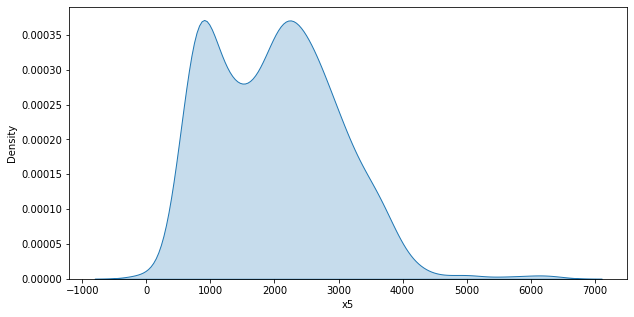

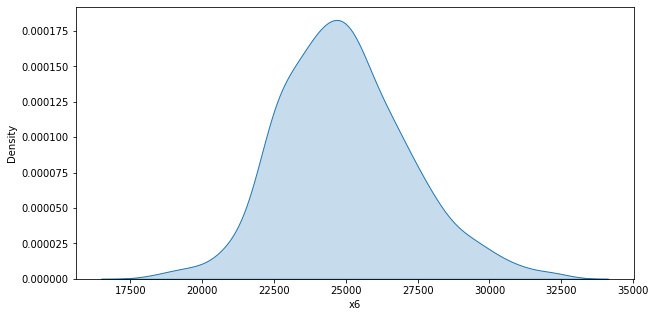

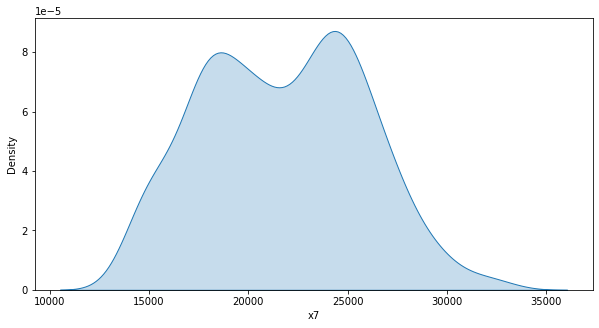

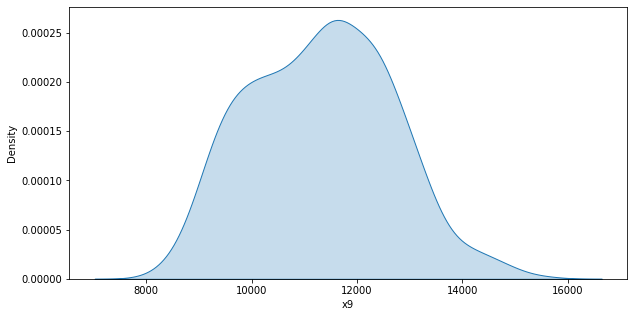

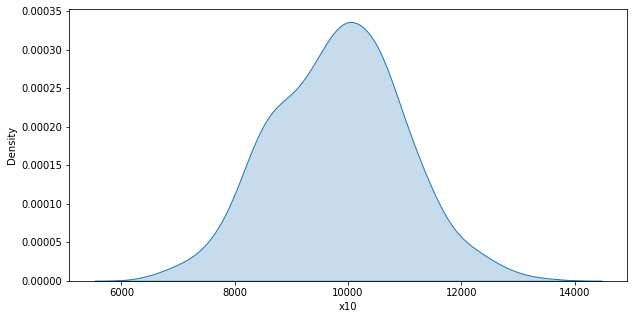

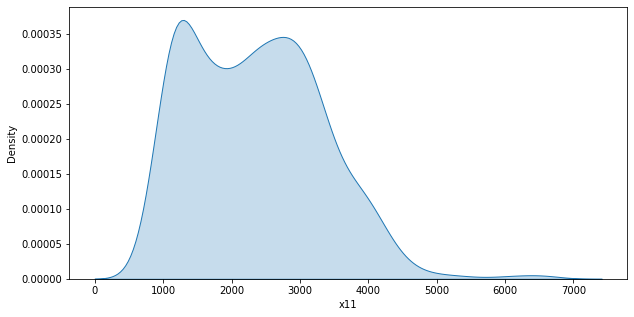

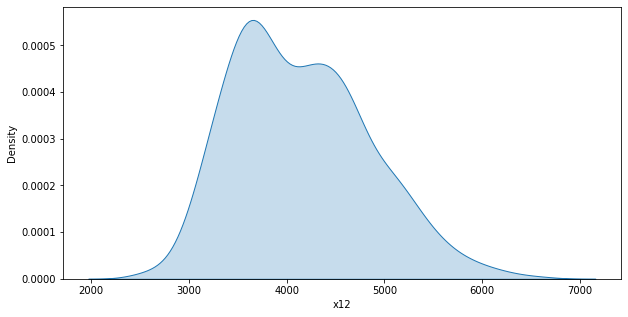

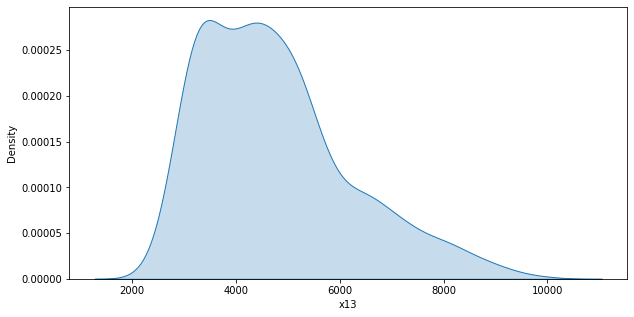

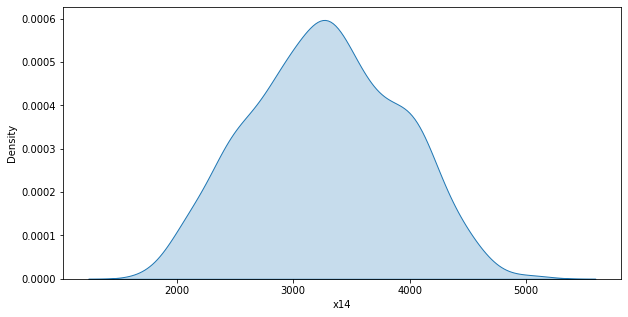

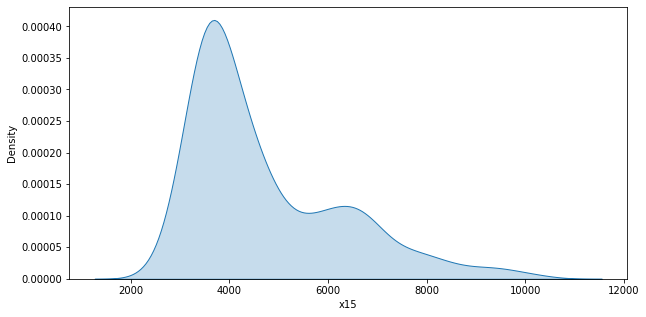

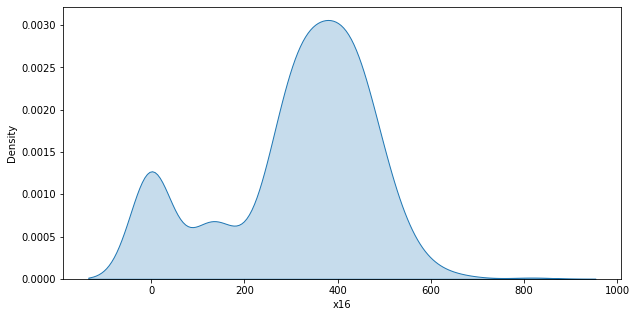

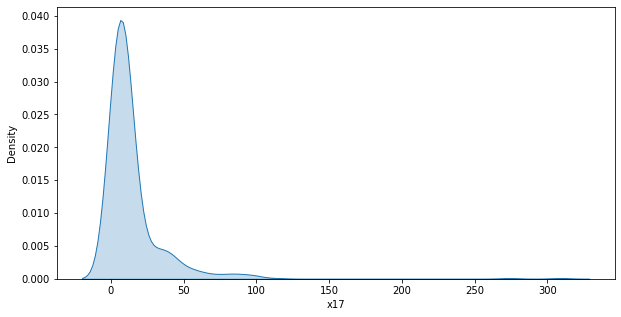

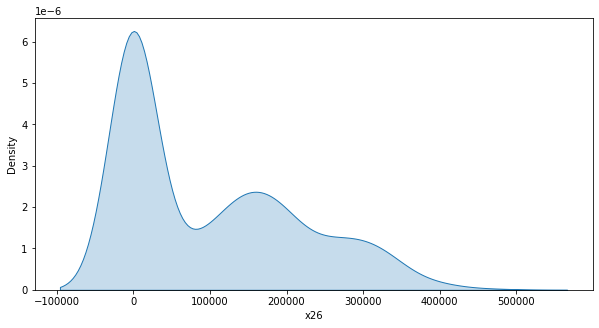

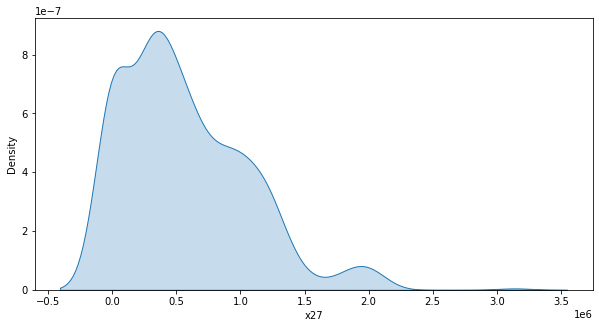

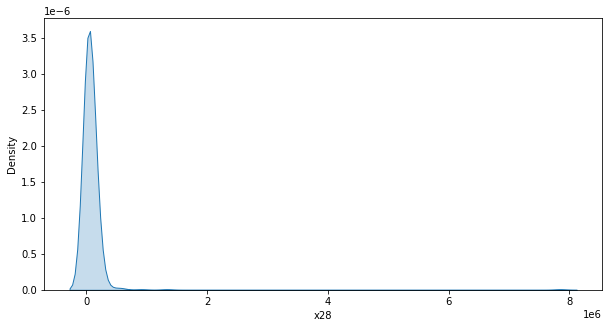

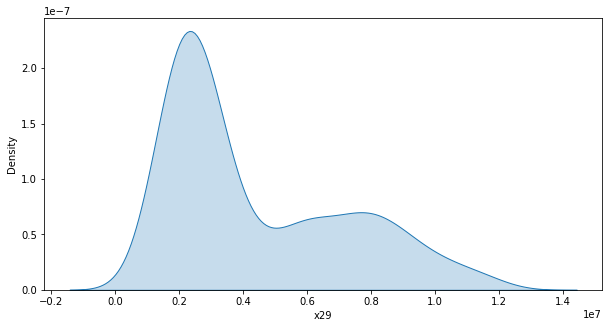

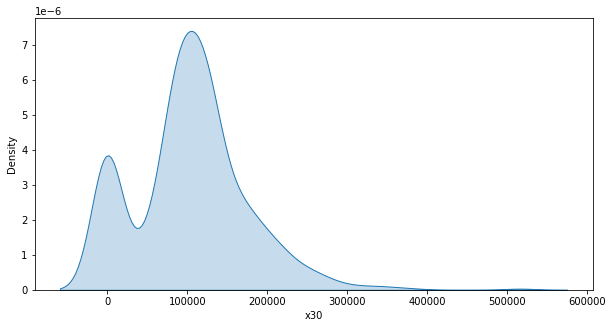

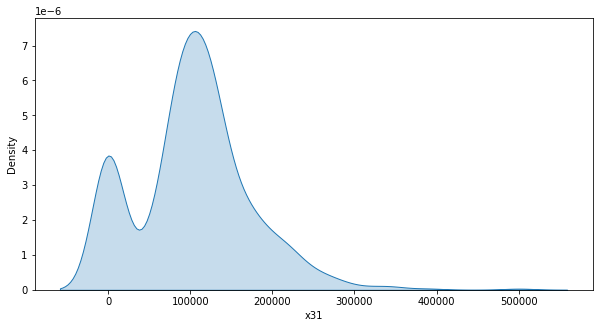

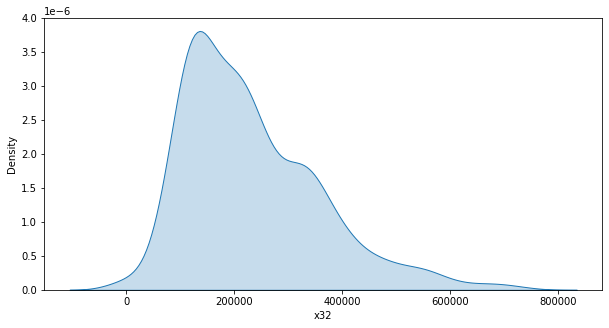

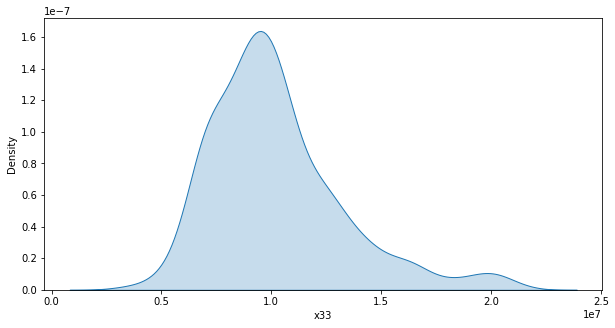

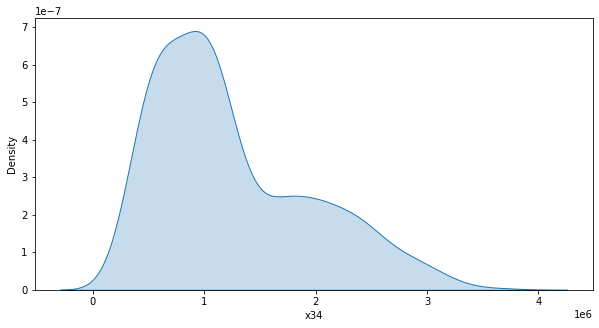

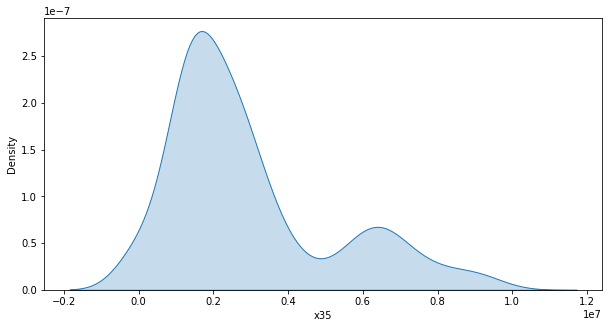

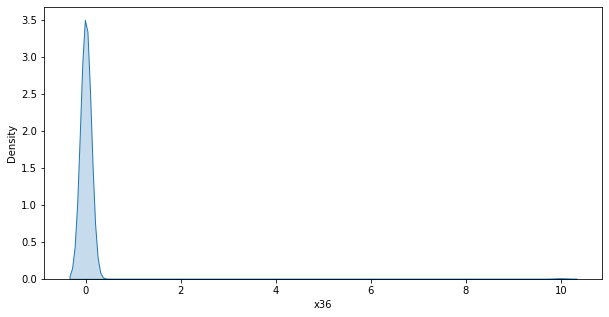

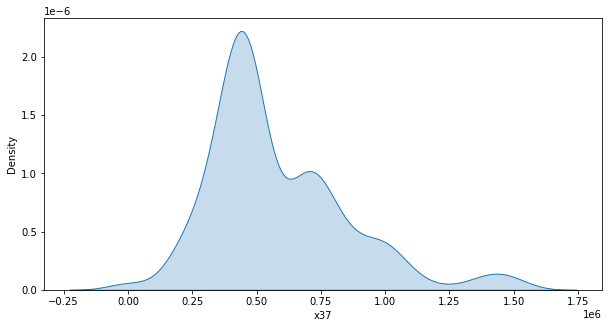

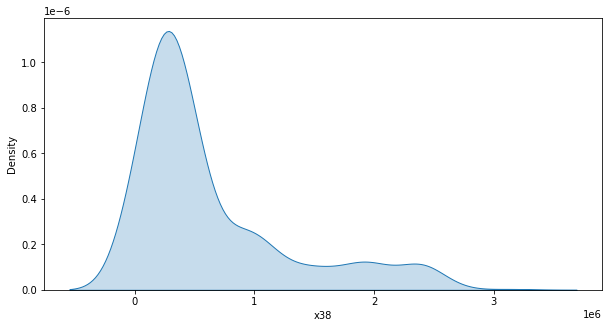

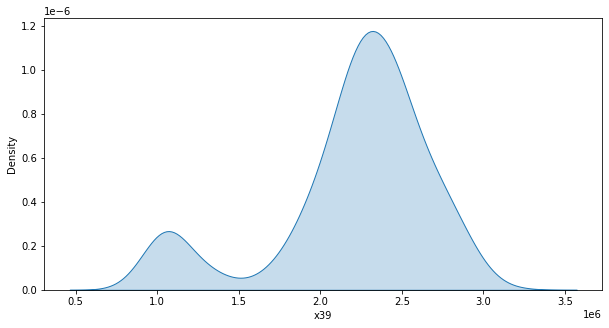

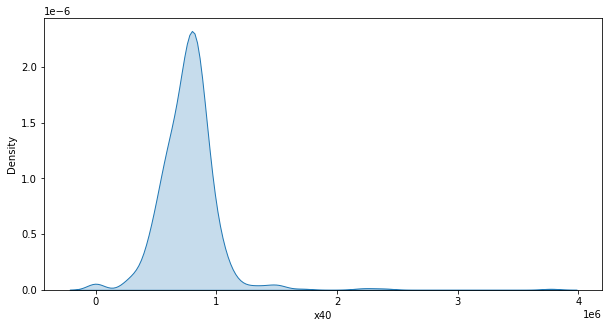

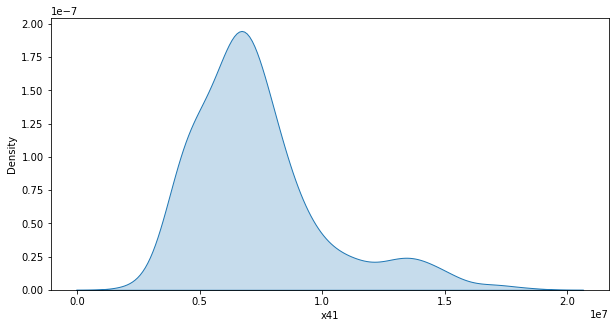

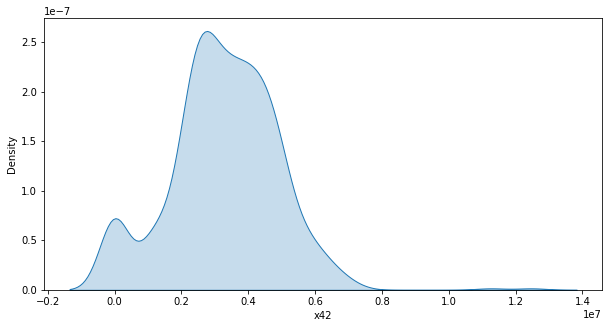

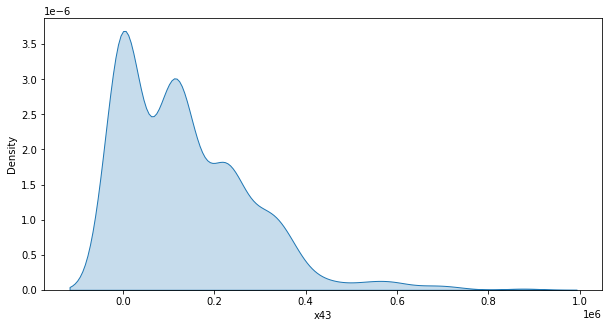

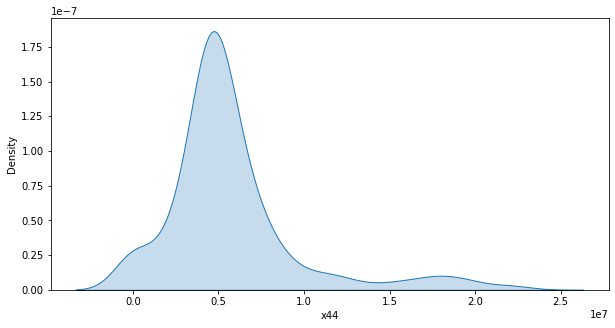

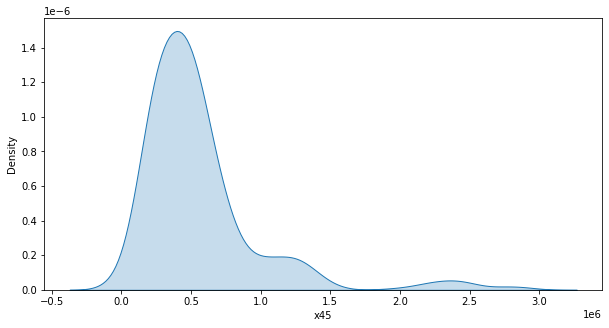

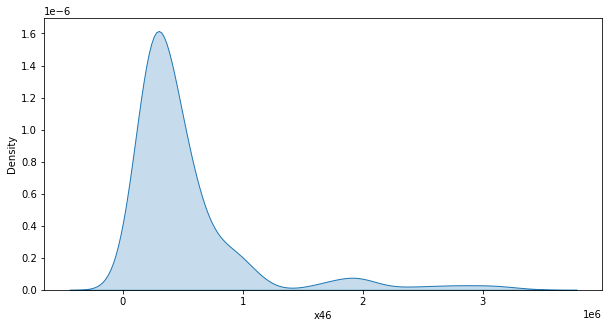

In [ ]:
'''
Optional:

Visualizing each series is useful to better understand the distribution each 
variable takes and to inspect if there are clear outliers in the data. Understanding
the distribution of the underlying data can also inform prior parameterization in
bayesian modeling approaches later on.

Based on visual inspection, one can determine if there are any obvious adjustments
that need to be made to the data.
'''

for i in range(2,len(featureset_df.columns)):
  plt.figure()
  sns.kdeplot(featureset_df[featureset_df.columns[i]], label = featureset_df.columns[i], shade = True)

## 5) Feature Creation

### 5.1) Check for Seasonality and add Flag

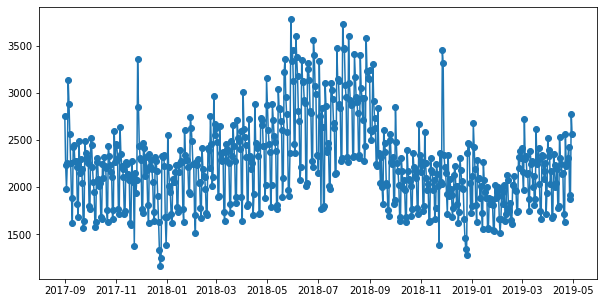

In [ ]:
'''
View the target variable as a time series plot and identify periods where data peaks.

In this specific example, conversions spike on Mondays, so we will create
a specific flag (0/1 variable) for that day and use it as a control feature in 
our feature set.
'''
plt.plot_date(df.index, target_variable, linestyle = '-')

In [ ]:
featureset_df['Is_Monday'] = (df.index.get_level_values(0).weekday == 0).astype(int)
featureset_df['Is_Q2Q3'] = (df.index.get_level_values(0).month == 4).astype(int) | (df.index.get_level_values(0).month == 5).astype(int) | (df.index.get_level_values(0).month == 6).astype(int) | (df.index.get_level_values(0).month == 7).astype(int) | (df.index.get_level_values(0).month == 8).astype(int) | (df.index.get_level_values(0).month == 9).astype(int)

### 5.2) Lag, Carryover, Diminishing Returns

In [ ]:
'''
We'll need to transform the raw data by applying lag, carryover, and diminishing 
returns to have it most accuratley predict the target variable. 

Split the df into two different dataframes:

1) Features that don't need to be transformed
    - Examples are: date, target variable, any flag that has been added as a control
    variable (seasonality, promotions, etc.)

2) Features that need to be transformed
    - Paid media tactics and any other feature where there is some sort of delayed
    response with the target variable


If you are using daily data, the lag should at default be 14.
If you are using weekly data, the lag should at default be 5.

These values are starting points for lags, but others can and should be tested to
determine the best lag length for your specific data.
'''


"\nWe'll need to transform the raw data by applying lag, carryover, and diminishing \nreturns to have it most accuratley predict the target variable. \n\nSplit the df into two different dataframes:\n\n1) Features that don't need to be transformed\n    - Examples are: date, target variable, any flag that has been added as a control\n    variable (seasonality, promotions, etc.)\n\n2) Features that need to be transformed\n    - Paid media tactics and any other feature where there is some sort of delayed\n    response with the target variable\n\n\nIf you are using daily data, the lag should at default be 14.\nIf you are using weekly data, the lag should at default be 5.\n"

In [ ]:
# Variables that do not need to be transformed

untransformed_df = pd.concat([target_variable, featureset_df[['Is_Monday','Is_Q2Q3']]], axis = 1) #Target variable + controls

In [ ]:
# Variables that do need to be transformed

#exclude dummies/controls that do not need to be transformed
#transformed_df = featureset_df[['feature1', 'feature2',...]]

'''
In this example case, almost all of the features in the featureset_df are media features.
As more dummy variables or other control variables are added, the user will need to 
specify which columns should be transformed
'''
transformed_df = featureset_df.loc[:,~featureset_df.columns.isin(['Is_Monday','Is_Q2Q3'])]

In [ ]:
#This function creates the different combinations of Lag, Decay, and Curve
def transformation(dataframe,x):
    lag = []
    for i in range(0, 7, 1):
        data = dataframe[x].shift(i).to_frame()
        data.columns = [col_name+'Lag'+str(i)for col_name in data.columns]
        # store DataFrame in list
        lag.append(data)
    # see pd.concat documentation for more info
    lag = pd.concat(lag,axis=1)
    lag=lag.fillna(0)
    Alpha = []
    for i in np.linspace(0.6,1.0,num=5):
        data = pow(lag,i)
        data.columns = [col_name+'Alpha'+str(i)for col_name in data.columns]
    # store DataFrame in list
        Alpha.append(data)
    # see pd.concat documentation for more info
    Alpha = pd.concat(Alpha,axis=1)  
    Decay=[]
    #j = 0
    for percent in np.linspace(0.6,1.0,5):
        data = Alpha.copy()
        data.columns = [col_name+'Decay'+str(percent)for col_name in data.columns]
        for i in range(0,len(Alpha)):
            for j in range(0,len(Alpha.columns)):
            #data = data + data.shift(1)*(1-i)
                if(i == 0):
                    data.iloc[i, j] = data.iloc[i, j]*percent
                else:
                    data.iloc[i, j] = data.iloc[i - 1, j] *(1-percent) + data.iloc[i,j] * percent
        Decay.append(data)
        j = j + 1
    Decay = pd.concat(Decay,axis=1)
    
    return Decay

In [ ]:
'''
Make sure data is correctly sorted by date before running feature selection algo.
This is important because the algorithm takes from a previous row of the data as it
evaluates the current row. Unsorted data can cause errors in resulting feature selection
info.
'''
transformed_df = transformed_df.sort_values('date')

In [ ]:
'''
WARNING: This section of the code is estimated to take 10-30 minutes to complete
depending on weekly vs daily data and the number of features in the model.
'''

columns = transformed_df.columns
sales = target_variable
all_data = [] 
for col in columns:
  newdf = transformation(transformed_df, col)
  corr_df = pd.concat([sales, newdf], axis=1)
  corr = corr_df.corr().sort_values(kpi_col,ascending=False) 
  new_vals= corr.iloc[1:4 , 0:1].index.tolist() 
  data = newdf[new_vals]
  all_data.append(data)
transformed_df = pd.concat(all_data,axis=1)

## 6) Feature Selection

In [ ]:
'''
For feature selection we employ the Boruta algorithm.

More information here:
https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a

This algorithm will tell you the rank of each feature and whether or not to keep 
a varaible in the model (i.e. Keep  = True/False). The goal of RBA is to optimize
across all paid digital media tactics, therefore select the top ranking feature
for each group of features (whether or not the algorithm tells you to keep the
feature).
'''

'\nFor feature selection we employ the Boruta algorithm.\n\nMore information here:\nhttps://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a\n\nThis algorithm will tell you the rank of each feature and whether or not to keep \na varaible in the model (i.e. Keep  = True/False). The goal of RBA is to optimize\nacross all paid digital media tactics, therefore select the top ranking feature\nfor each group of features (whether or not the algorithm tells you to keep the\nfeature).\n'

In [ ]:
# Specifiying the target and x variables
y = target_variable
x = transformed_df #update with transformed features

In [ ]:
# define random forest classifier
forest = RandomForestRegressor(n_jobs=-1, max_depth=5)
forest.fit(x, y)

RandomForestRegressor(max_depth=5, n_jobs=-1)

In [ ]:
# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features
feat_selector.fit(np.array(x), np.array(y))

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(np.array(x))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	105
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	105
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	105
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	105
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	105
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	105
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	105
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	27
Tentative: 	30
Rejected: 	48
Iteration: 	9 / 100
Confirmed: 	27
Tentative: 	30
Rejected: 	48
Iteration: 	10 / 100
Confirmed: 	27
Tentative: 	30
Rejected: 	48
Iteration: 	11 / 100
Confirmed: 	27
Tentative: 	30
Rejected: 	48
Iteration: 	12 / 100
Confirmed: 	28
Tentative: 	29
Rejected: 	48
Iteration: 	13 / 100
Confirmed: 	28
Tentative: 	29
Rejected: 	48
Iteration: 	14 / 100
Confirmed: 	28
Tentative: 	29
Rejected: 	48
Iteration: 	15 / 100
Confirmed: 	28
Tentative: 	29
Rejected: 	48
Iteration: 	16 / 100
Confirmed: 	30
Tenta

In [ ]:
#Select the top ranking variable for each group of variables. 
feature_ranks = list(zip(x.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('{:<25}, Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

x3Lag0Alpha0.6Decay1.0   , Rank: 7,  Keep: False
x3Lag0Alpha0.7Decay1.0   , Rank: 7,  Keep: False
x3Lag0Alpha0.8Decay1.0   , Rank: 7,  Keep: False
x4Lag0Alpha1.0Decay0.9   , Rank: 1,  Keep: True
x4Lag0Alpha0.9Decay0.9   , Rank: 1,  Keep: True
x4Lag0Alpha0.8Decay0.9   , Rank: 1,  Keep: True
x5Lag0Alpha1.0Decay1.0   , Rank: 1,  Keep: True
x5Lag0Alpha0.9Decay1.0   , Rank: 1,  Keep: True
x5Lag0Alpha0.8Decay1.0   , Rank: 1,  Keep: True
x6Lag0Alpha0.6Decay1.0   , Rank: 1,  Keep: True
x6Lag0Alpha0.7Decay1.0   , Rank: 1,  Keep: True
x6Lag0Alpha0.8Decay1.0   , Rank: 1,  Keep: True
x7Lag0Alpha0.6Decay1.0   , Rank: 1,  Keep: True
x7Lag0Alpha0.7Decay1.0   , Rank: 1,  Keep: True
x7Lag0Alpha0.8Decay1.0   , Rank: 1,  Keep: True
x9Lag0Alpha1.0Decay0.9   , Rank: 25,  Keep: False
x9Lag0Alpha0.9Decay0.9   , Rank: 21,  Keep: False
x9Lag0Alpha0.8Decay0.9   , Rank: 18,  Keep: False
x10Lag0Alpha1.0Decay1.0  , Rank: 1,  Keep: True
x10Lag0Alpha0.9Decay1.0  , Rank: 1,  Keep: True
x10Lag0Alpha0.8Decay1.0  , Rank

In [ ]:
'''
Reduce the overall dataset to just selected features using the ranking
from the Boruta output, and save to a dataframe
'''


selected_featureset_df = transformed_df[['x3Lag0Alpha0.6Decay1.0',
'x4Lag0Alpha1.0Decay0.9',
'x5Lag0Alpha1.0Decay1.0',
'x6Lag0Alpha0.6Decay1.0',
'x7Lag0Alpha0.6Decay1.0',
'x9Lag0Alpha0.8Decay0.9',
'x10Lag0Alpha1.0Decay1.0',
'x11Lag0Alpha0.8Decay1.0',
'x12Lag0Alpha1.0Decay1.0',
'x13Lag0Alpha0.8Decay1.0',
'x14Lag0Alpha1.0Decay1.0',
'x15Lag0Alpha0.7Decay1.0',
'x16Lag0Alpha1.0Decay0.9',
'x17Lag1Alpha0.8Decay0.7',
'x26Lag0Alpha1.0Decay0.9',
'x27Lag5Alpha1.0Decay1.0',
'x28Lag3Alpha0.7Decay0.6',
'x29Lag0Alpha0.6Decay1.0',
'x30Lag4Alpha1.0Decay1.0',
'x31Lag5Alpha1.0Decay1.0',
'x32Lag0Alpha0.6Decay0.9',
'x33Lag0Alpha1.0Decay1.0',
'x34Lag0Alpha1.0Decay1.0',
'x35Lag5Alpha0.6Decay1.0',
'x36Lag0Alpha0.7Decay0.8',
'x37Lag5Alpha0.6Decay1.0',
'x38Lag3Alpha0.6Decay0.7',
'x39Lag0Alpha0.9Decay1.0',
'x40Lag4Alpha0.6Decay0.7',
'x41Lag0Alpha1.0Decay1.0',
'x42Lag0Alpha0.7Decay1.0',
'x43Lag6Alpha0.6Decay0.9',
'x44Lag0Alpha0.6Decay0.8',
'x45Lag0Alpha0.8Decay1.0',
'x46Lag0Alpha0.6Decay0.9',
]]

In [ ]:
# add back in the untransformed control variables to the featureset
selected_featureset_df = pd.concat([selected_featureset_df,untransformed_df[untransformed_df.columns[untransformed_df.columns != kpi_col]]],axis = 1)

## 7) Feature Scaling

### 7.1) Feature Scaling

In [ ]:
'''
The default method of standardization utilizes Standard Scaler, which takes in
input data and transforms so that the output has mean 0 and standard deviation of 1
across all features.

Alternative methods of feature scaling include square-root transformation,
de-meaning, natural log transformations, Min-Max Scalers, or normalization
'''

In [ ]:
scaler = StandardScaler()
standardized_transform = scaler.fit_transform(selected_featureset_df)
selected_featureset_df = pd.DataFrame(standardized_transform, columns = selected_featureset_df.columns)

In [ ]:
'''
Option to review visuals of the data. After the data is standardized the distributions
may take on a more normal shape.


for i in range(0,len(X_transform_stand.columns)):
  plt.figure()
  sns.kdeplot(X_transform_stand[X_transform_stand.columns[i]], label = X_transform_stand.columns[i], shade = True)
'''

In [ ]:
selected_featureset_df.head()

,x3Lag0Alpha0.6Decay1.0,x4Lag0Alpha1.0Decay0.9,x5Lag0Alpha1.0Decay1.0,x6Lag0Alpha0.6Decay1.0,x7Lag0Alpha0.6Decay1.0,x9Lag0Alpha0.8Decay0.9,x10Lag0Alpha1.0Decay1.0,x11Lag0Alpha0.8Decay1.0,x12Lag0Alpha1.0Decay1.0,x13Lag0Alpha0.8Decay1.0,x14Lag0Alpha1.0Decay1.0,x15Lag0Alpha0.7Decay1.0,x16Lag0Alpha1.0Decay0.9,x17Lag1Alpha0.8Decay0.7,x26Lag0Alpha1.0Decay0.9,x27Lag5Alpha1.0Decay1.0,x28Lag3Alpha0.7Decay0.6,x29Lag0Alpha0.6Decay1.0,x30Lag4Alpha1.0Decay1.0,x31Lag5Alpha1.0Decay1.0,x32Lag0Alpha0.6Decay0.9,x33Lag0Alpha1.0Decay1.0,x34Lag0Alpha1.0Decay1.0,x35Lag5Alpha0.6Decay1.0,x36Lag0Alpha0.7Decay0.8,x37Lag5Alpha0.6Decay1.0,x38Lag3Alpha0.6Decay0.7,x39Lag0Alpha0.9Decay1.0,x40Lag4Alpha0.6Decay0.7,x41Lag0Alpha1.0Decay1.0,x42Lag0Alpha0.7Decay1.0,x43Lag6Alpha0.6Decay0.9,x44Lag0Alpha0.6Decay0.8,x45Lag0Alpha0.8Decay1.0,x46Lag0Alpha0.6Decay0.9,Is_Monday,Is_Q2Q3
0,3.008847,-0.013308,0.768235,2.531964,1.487371,-0.769416,1.441281,0.725535,-1.095420,2.789208,-1.089896,2.955954,0.300385,-0.963249,1.546737,-1.132744,-0.816974,-0.817743,-1.440384,-1.441319,1.602260,-0.208043,-0.162083,-2.019874,-0.049772,-3.30921,-1.493990,0.380115,-5.054326,0.728328,0.999370,-1.182702,-1.335387,4.076822,1.716164,-0.409033,1.223905
1,2.000557,0.194234,1.155649,2.067408,0.494373,0.311906,0.033864,1.173717,-1.156667,2.196106,-1.711119,2.012929,0.841988,0.766437,2.037116,-1.132744,-0.816974,-0.482060,-1.440384,-1.441319,1.954234,-0.678859,-0.369799,-2.019874,-0.049772,-3.30921,-1.493990,0.284875,-5.054326,0.065629,0.432046,-1.182702,-1.087854,3.950294,2.348124,-0.409033,1.223905
2,1.523931,-0.363018,0.792898,0.871646,0.259303,-0.084936,-0.715315,0.735333,-1.279162,1.737237,-1.891577,1.342506,0.681540,1.419075,2.055175,-1.132744,-0.816974,-0.516666,-1.440384,-1.441319,2.113637,-0.309003,-0.185793,-2.019874,-0.049772,-3.30921,-1.493990,0.117347,-5.054326,0.097992,0.162302,-1.182702,-0.795315,3.947078,2.357568,-0.409033,1.223905
3,1.834188,-0.101048,0.961428,1.289125,0.363954,0.104696,-0.084792,0.960874,-1.259221,1.974811,-1.767013,1.553768,0.755857,1.379121,2.259397,-1.132744,-0.816974,-0.657578,-1.440384,-1.441319,2.265821,1.244566,-0.195941,-2.019874,-0.049772,-3.30921,0.553442,0.329894,-5.054326,0.181991,0.474810,-1.182702,-1.056222,3.879606,2.354957,2.444793,1.223905
4,3.220380,2.028428,1.568754,3.069274,2.470641,1.444465,2.662485,1.700032,-0.690904,2.954997,-1.240012,3.254634,0.977896,1.536325,2.417670,-1.132744,-0.816974,-0.874567,-0.007337,-1.441319,2.910827,1.245268,-0.306189,-2.019874,-0.049772,-3.30921,1.474494,0.425175,-1.944316,0.984575,0.348492,-1.182702,-0.940561,4.556638,3.393967,-0.409033,1.223905


## 8) Handle Multicollinearity (reduce feature set)

In [ ]:
'''
Note: A max of 50 features is recommended for 24 months of data due to risk of overfitting. 

Run variance inflation factor analysis and output results to flag multicollinearity
above specified threshold
'''

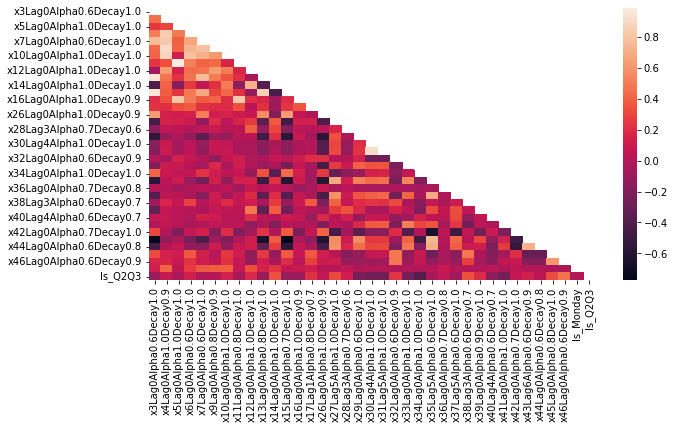

In [ ]:
'''
Print a correlation heatmap to visualize correlation across feature set
'''

correl = selected_featureset_df.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(correl)

# using the upper triangle matrix as mask 
sns.heatmap(correl, mask=matrix)

In [ ]:
'''
Run VIF analysis and flag values greater than 7
Industry best practice flags values above 10 as a violation of regression model 
assumptions
'''

vif = add_constant(selected_featureset_df)

# loop to calculate the VIF for each X 
vif = pd.Series([variance_inflation_factor(vif.values, i) 
      for i in range(vif.shape[1])], 
      index=vif.columns) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# processing to output VIF results as a dataframe 
vif_df=vif.to_frame().reset_index()

vif_df.columns = ['feature', 'vif']
vif_df=vif_df.replace([np.inf], np.nan) # replace inf calculations as missing and zero fill 
vif_df=vif_df.fillna(0).sort_values(by="vif", ascending=False)

In [ ]:
vif_df.reset_index(inplace = True)
vif_df

,index,feature,vif
0,1,x3Lag0Alpha0.6Decay1.0,74.543021
1,2,x4Lag0Alpha1.0Decay0.9,70.378389
2,8,x11Lag0Alpha0.8Decay1.0,41.448324
3,12,x15Lag0Alpha0.7Decay1.0,40.989794
4,5,x7Lag0Alpha0.6Decay1.0,40.084069
5,3,x5Lag0Alpha1.0Decay1.0,39.876836
6,6,x9Lag0Alpha0.8Decay0.9,37.537886
7,10,x13Lag0Alpha0.8Decay1.0,32.992713
8,7,x10Lag0Alpha1.0Decay1.0,30.170118
9,4,x6Lag0Alpha0.6Decay1.0,19.204700


In [ ]:
'''
Drop the highest VIF features and print the high collinearity columns in a list
'''
high_collinearity_columns = vif_df.feature[vif_df['vif'] >= 7].to_list()

In [ ]:
high_collinearity_columns

['x3Lag0Alpha0.6Decay1.0',
 'x4Lag0Alpha1.0Decay0.9',
 'x11Lag0Alpha0.8Decay1.0',
 'x15Lag0Alpha0.7Decay1.0',
 'x7Lag0Alpha0.6Decay1.0',
 'x5Lag0Alpha1.0Decay1.0',
 'x9Lag0Alpha0.8Decay0.9',
 'x13Lag0Alpha0.8Decay1.0',
 'x10Lag0Alpha1.0Decay1.0',
 'x6Lag0Alpha0.6Decay1.0',
 'x14Lag0Alpha1.0Decay1.0',
 'x12Lag0Alpha1.0Decay1.0',
 'x43Lag6Alpha0.6Decay0.9']

In [ ]:
'''
Drop 1 variable at a time (start with the highest VIF) and re-run the VIF cell to
re-check multicollinearity. This will allow the user to preserve as many features
in the model as possible
'''

cols_to_drop = []
while vif_df.vif[0] >= 7:
  if vif_df.vif[0] >= 7:
    cols_to_drop.append(vif_df.feature[0])
    selected_featureset_df.drop(columns = vif_df.feature[0],inplace = True) 
    vif = add_constant(selected_featureset_df)
  # loop to calculate the VIF for each X 
    vif = pd.Series([variance_inflation_factor(vif.values, i) 
    for i in range(vif.shape[1])], index=vif.columns) 
    # processing to output VIF results as a dataframe 
    vif_df=vif.to_frame().reset_index()
    vif_df.columns = ['feature', 'vif']
    vif_df=vif_df.replace([np.inf], np.nan) # replace inf calculations as missing and zero fill 
    vif_df=vif_df.fillna(0).sort_values(by="vif", ascending=False)
    vif_df.reset_index(inplace = True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
cols_to_drop

['x3Lag0Alpha0.6Decay1.0',
 'x4Lag0Alpha1.0Decay0.9',
 'x11Lag0Alpha0.8Decay1.0',
 'x7Lag0Alpha0.6Decay1.0',
 'x15Lag0Alpha0.7Decay1.0',
 'x14Lag0Alpha1.0Decay1.0',
 'x9Lag0Alpha0.8Decay0.9',
 'x43Lag6Alpha0.6Decay0.9']

In [ ]:
selected_featureset_df.columns

Index(['x5Lag0Alpha1.0Decay1.0', 'x6Lag0Alpha0.6Decay1.0',
       'x10Lag0Alpha1.0Decay1.0', 'x12Lag0Alpha1.0Decay1.0',
       'x13Lag0Alpha0.8Decay1.0', 'x16Lag0Alpha1.0Decay0.9',
       'x17Lag1Alpha0.8Decay0.7', 'x26Lag0Alpha1.0Decay0.9',
       'x27Lag5Alpha1.0Decay1.0', 'x28Lag3Alpha0.7Decay0.6',
       'x29Lag0Alpha0.6Decay1.0', 'x30Lag4Alpha1.0Decay1.0',
       'x31Lag5Alpha1.0Decay1.0', 'x32Lag0Alpha0.6Decay0.9',
       'x33Lag0Alpha1.0Decay1.0', 'x34Lag0Alpha1.0Decay1.0',
       'x35Lag5Alpha0.6Decay1.0', 'x36Lag0Alpha0.7Decay0.8',
       'x37Lag5Alpha0.6Decay1.0', 'x38Lag3Alpha0.6Decay0.7',
       'x39Lag0Alpha0.9Decay1.0', 'x40Lag4Alpha0.6Decay0.7',
       'x41Lag0Alpha1.0Decay1.0', 'x42Lag0Alpha0.7Decay1.0',
       'x44Lag0Alpha0.6Decay0.8', 'x45Lag0Alpha0.8Decay1.0',
       'x46Lag0Alpha0.6Decay0.9', 'Is_Monday', 'Is_Q2Q3'],
      dtype='object')

In [ ]:
len(selected_featureset_df.columns)

29

In [ ]:
# Replace the decimal points with underscores so that data can be exported to BQ
selected_featureset_df.columns = selected_featureset_df.columns.str.replace(".","_")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


## 9) Export Final Dataset

### 9.1) Trim the final dataset according to lag

In [ ]:
final_df = selected_featureset_df
final_df['y1'] = target_variable.reset_index()[kpi_col]

In [ ]:
'''
Trim the start of your dataset to correspond with the max lag
(if max lag is 4 weeks, trim the first 4 weeks off of the data)
'''

final_df = final_df[5:]
final_df.reset_index(inplace = True)
final_df.drop(columns = 'index',inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
final_df.head()

,x5Lag0Alpha1_0Decay1_0,x6Lag0Alpha0_6Decay1_0,x10Lag0Alpha1_0Decay1_0,x12Lag0Alpha1_0Decay1_0,x13Lag0Alpha0_8Decay1_0,x16Lag0Alpha1_0Decay0_9,x17Lag1Alpha0_8Decay0_7,x26Lag0Alpha1_0Decay0_9,x27Lag5Alpha1_0Decay1_0,x28Lag3Alpha0_7Decay0_6,x29Lag0Alpha0_6Decay1_0,x30Lag4Alpha1_0Decay1_0,x31Lag5Alpha1_0Decay1_0,x32Lag0Alpha0_6Decay0_9,x33Lag0Alpha1_0Decay1_0,x34Lag0Alpha1_0Decay1_0,x35Lag5Alpha0_6Decay1_0,x36Lag0Alpha0_7Decay0_8,x37Lag5Alpha0_6Decay1_0,x38Lag3Alpha0_6Decay0_7,x39Lag0Alpha0_9Decay1_0,x40Lag4Alpha0_6Decay0_7,x41Lag0Alpha1_0Decay1_0,x42Lag0Alpha0_7Decay1_0,x44Lag0Alpha0_6Decay0_8,x45Lag0Alpha0_8Decay1_0,x46Lag0Alpha0_6Decay0_9,Is_Monday,Is_Q2Q3,y1
0,1.644799,2.479218,2.077866,-0.816247,2.762416,1.090461,1.549978,2.114491,-0.218986,-0.816974,-0.692751,-0.037267,0.163267,2.251033,0.579849,-0.241582,-0.811498,-0.049772,-0.148801,1.736670,0.013414,-1.214325,0.207515,0.024181,-0.906952,3.348332,2.353993,-0.409033,1.223905,2886
1,0.861749,2.015967,1.557338,-1.138151,2.445156,0.785454,1.486572,2.578709,-0.371315,-0.816974,-0.951762,0.185745,0.183927,1.910781,0.220581,-0.122751,-0.628570,-0.049772,-0.104909,1.795285,0.634338,-0.905818,0.553133,-0.388687,-0.937239,3.624571,2.669086,-0.409033,1.223905,2569
2,0.830920,1.666998,1.033346,-1.179457,2.083145,0.698477,1.433548,2.301353,-0.263434,-0.816974,-0.748264,0.125885,0.106779,1.509317,-0.892229,-0.044386,-0.854458,-0.049772,-0.283482,1.751210,0.199942,-0.573542,0.485353,-0.231300,-0.992511,3.525182,2.598373,-0.409033,1.223905,2253
3,1.122765,1.193371,-0.494459,-1.653766,1.807850,0.695427,2.825969,1.895600,-0.404478,-0.816974,-1.004525,0.167120,0.111411,1.363297,-0.869597,0.045691,-0.685972,-0.049772,-0.328174,1.344736,-2.101294,-0.639788,0.026734,-0.401073,-0.934625,3.673877,2.455786,-0.409033,1.223905,1888
4,0.970677,2.554191,0.258184,-1.373169,3.346109,0.757245,3.066966,2.616652,0.747115,-0.816974,-0.829660,-0.027117,0.198798,1.161648,-0.532306,-0.241051,-0.771502,-0.049772,-0.318071,1.356809,0.609138,-0.739149,0.111755,-0.129384,-0.992994,3.862814,2.432739,-0.409033,1.223905,1623


In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [ ]:
destination_project_id = "" #@param
destination_dataset = "RBA_demo" #@param
destination_table = "cleaned_data_2_23_22" #@param
dataset_table = destination_dataset+"."+destination_table

final_df.to_gbq(dataset_table, 
                 destination_project_id,
                 chunksize=None, 
                 if_exists='replace'
                 )

1it [00:03,  3.11s/it]
